In [ ]:
import gensim
import re
import spacy
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import CSVLogger,EarlyStopping,ModelCheckpoint

# Clean/Normalize Arabic Text
def clean_str(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ']
    
    #remove tashkeel
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(p_tashkeel,"", text)
    
    #remove longation
    p_longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)
    
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])
    
    #trim    
    text = text.strip()

    return text

In [ ]:
#!wget https://archive.org/download/full_grams_cbow_300_twitter/full_grams_cbow_300_twitter.zip
#!unzip full_grams_cbow_300_twitter.zip

# Nouvelle section

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# load the AraVec model
model = gensim.models.Word2Vec.load("/content/drive/MyDrive/DataMem/full_grams_cbow_300_twitter/full_grams_cbow_300_twitter.mdl")
print("We've",len(model.wv.index2word),"vocabularies")

We've 1476715 vocabularies


# Nouvelle section

In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
import nltk
#import nltk as nlp
import string
import re


In [ ]:
df= pd.read_excel('/content/drive/MyDrive/DataMem/LabeledDataset.xlsx')

In [ ]:
df.Class.value_counts()

0    11521
1     3529
Name: Class, dtype: int64

In [ ]:
!pip install  alphabet_detector 


  Created wheel for alphabet-detector: filename=alphabet_detector-0.0.7-cp37-none-any.whl size=2446 sha256=08c878a1dc56aaf87807cb6afaf72821341f852f72831151cf3e68c83d040918
  Stored in directory: /root/.cache/pip/wheels/75/a7/c3/faf515469622e565475fc96983418ba6e03f6a0f73755cd892
Successfully built alphabet-detector


In [ ]:
# Pretraitement data
 
import re
import string
from alphabet_detector import AlphabetDetector
from bs4 import BeautifulSoup
#definition des diactrics
arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

#Suppression des diactrics
def remove_diacritics(text):  #إزالة علامات التشكيل *
    text = re.sub(arabic_diacritics, '', text)
    return text

#Suppression de punctuations
def remove_punctuation(s): 
    my_punctuations = string.punctuation + "،" + "؛" + "؟" + "«" + "»" + "!"
    translator = str.maketrans('', '', my_punctuations)
    return s.translate(translator)


def remove_punctuation2(s): # replace punctuation with space
    my_punctuations = string.punctuation + "،" + "؛" + "؟" + "«" + "»"
    replace_table = str.maketrans(my_punctuations,  ' '*len(my_punctuations))
    return s.translate(replace_table)

#remove text change from html to text
def html2text(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()


#remove other letters
def remove_links(text):
 
    return re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)

# remove empty lines
def remove_empty_lines(text):
    lines = [s.rstrip() for s in text.split("\n") if s.rstrip()]
    return '\n'.join(lines)


def remove_repeating_char(text):
    # return re.sub(r'(.)\1+', r'\1', text)     # keep only 1 repeat
    return re.sub(r'(.)\1+', r'\1\1', text)  # keep 2 repeat

#remove any othe language letters
def keep_only_arabic(text):
    ad = AlphabetDetector()
    clean_lines = list()
    for line in text.splitlines():
        clean_line = list()
        for word in line.split():
            if len(word) > 1:
                if ad.is_arabic(word):
                    if word.isalpha():
                        clean_line.append(word)
        clean_lines.append(' '.join(clean_line))
    return '\n'.join(clean_lines)


def clean_doc(text):
    text = html2text(text)
  
    text = text.replace('\\', ' ')
    text = text.replace('/', ' ')
    text = text.replace('-', ' ')
    text = text.replace('(', ' ')
    text = text.replace(')', ' ')
    clean_text = remove_links(text)
    clean_text = remove_diacritics(clean_text)
    clean_text = remove_punctuation2(clean_text)
    clean_text = keep_only_arabic(clean_text)
    clean_text = remove_repeating_char(clean_text)
    clean_text = remove_empty_lines(clean_text)
    return clean_text


In [ ]:
#df['body'].values.tolist()
df['Tweet'] = df['Tweet'].astype(str).values
df['Tweet']=df['Tweet'].apply(clean_doc)
df['Tweet']=df['Tweet'].apply(clean_str)

In [ ]:
df.Class.value_counts()

0    11521
1     3529
Name: Class, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
X = df['Tweet'].astype(str).values
y= df['Class'].values
   
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
max_num_words=len(X_train)
print(max_num_words)

12040


In [ ]:
#df_train=pd.read_csv('/content/drive/MyDrive/DataMem/train_set_80p_Aljazeera.csv')
#X_train = df_train['Tweet'].astype(str).values
#y_train = df_train['Class'].values

In [ ]:
#df_test=pd.read_csv('/content/drive/MyDrive/DataMem/test_set_20p_Aljazeera.csv')
#X_val = df_test['Tweet'].astype(str).values
#y_val = df_test['Class'].values

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
max_num_words =max_num_words
max_length =283

tokenizer = Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(list(X_train))

list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_test = tokenizer.texts_to_sequences(X_val)

X_tr = pad_sequences(list_tokenized_train, maxlen=max_length, padding='post')
X_tes = pad_sequences(list_tokenized_test, maxlen=max_length, padding='post')


In [ ]:
# Identify max length of reviews
max_length = 0
for review_number in range(len(list_tokenized_train)):
  numberofwords=len(list_tokenized_train [review_number])
  if (numberofwords) > (max_length):
    max_length = numberofwords
print(max_length)

283


In [ ]:
# Show the vocabulory
word_index = tokenizer.word_index
print(tokenizer.word_index)
print('Found %s unique tokens.' % len(word_index))

{'من': 1, 'كاظم': 2, 'الله': 3, 'علي': 4, 'هه': 5, 'احلام': 6, 'في': 7, 'ما': 8, 'الي': 9, 'كل': 10, 'بس': 11, 'والله': 12, 'الساهر': 13, 'لا': 14, 'هذا': 15, 'ولا': 16, 'انا': 17, 'انتي': 18, 'مو': 19, 'لو': 20, 'القيصر': 21, 'هي': 22, 'هو': 23, 'عن': 24, 'ان': 25, 'اللي': 26, 'انت': 27, 'العراق': 28, 'واحد': 29, 'راغب': 30, 'او': 31, 'شي': 32, 'الكويت': 33, 'لان': 34, 'مع': 35, 'الناس': 36, 'شنو': 37, 'هاي': 38, 'اي': 39, 'ليش': 40, 'شو': 41, 'حتي': 42, 'عليه': 43, 'يعني': 44, 'ملكه': 45, 'كان': 46, 'فنان': 47, 'كلهم': 48, 'كاضم': 49, 'مش': 50, 'مضغوطين': 51, 'عراقي': 52, 'اني': 53, 'منو': 54, 'هذه': 55, 'الا': 56, 'منه': 57, 'تاج': 58, 'ابو': 59, 'فدوه': 60, 'ام': 61, 'فنانه': 62, 'مثل': 63, 'اصلا': 64, 'غير': 65, 'مصر': 66, 'احسن': 67, 'اذا': 68, 'انها': 69, 'العرب': 70, 'صوت': 71, 'الفن': 72, 'مين': 73, 'اول': 74, 'دي': 75, 'مره': 76, 'فيها': 77, 'عليها': 78, 'انو': 79, 'لبنان': 80, 'وين': 81, 'يا': 82, 'علامه': 83, 'منك': 84, 'انه': 85, 'وحده': 86, 'العربي': 87, 'جدا': 88, 'بالله

In [ ]:
len(list_tokenized_train)

12040

In [ ]:
X_tr.shape

(12040, 283)

In [ ]:
model["الجزائر"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 7.03658164e-01, -1.17206454e+00,  5.20509899e-01,  1.79336345e+00,
       -8.71224701e-01, -7.36100554e-01,  4.82115835e-01, -1.24040973e+00,
       -1.07708979e+00,  1.25925314e+00, -1.83763373e+00,  4.54997092e-01,
       -8.53953481e-01,  3.38911712e-01, -1.61027372e+00, -1.09810233e+00,
       -5.55308238e-02,  6.90826774e-01,  5.31724334e-01,  1.81677234e+00,
        4.46090937e-01,  6.63624406e-01,  7.58774519e-01,  9.54323828e-01,
       -1.52540123e+00,  8.54157805e-01,  8.68102163e-03, -1.54378521e+00,
        1.43151319e+00,  4.97710705e-01, -3.91972452e-01,  9.24101293e-01,
        1.47198272e+00, -1.13544583e+00, -3.78376208e-02,  9.40275967e-01,
       -8.52677882e-01, -4.73342806e-01, -2.84870535e-01, -2.47993708e+00,
       -5.88883221e-01, -2.84091473e-01, -2.47201577e-01, -3.50306988e-01,
       -6.83169603e-01,  1.19394457e+00,  5.59217572e-01, -7.40278184e-01,
       -7.89027393e-01, -7.10870326e-01, -1.01076615e+00,  3.44163664e-02,
        2.05796242e+00,  

In [ ]:
unique_words = len(word_index)
total_words = unique_words+1
skipped_words = 0
embedding_dim = 300  
embedding_matrix = np.zeros((total_words, embedding_dim))
for word, index in tokenizer.word_index.items():
  try:
        embedding_vector = model[word]
  except:
    skipped_words = skipped_words+1
    pass
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector
print("Embeddings Matrix shape : ",embedding_matrix.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


Embeddings Matrix shape :  (27586, 300)


In [ ]:
embedding_matrix[27498]-model.wv['تمس']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
from tensorflow.keras.layers import *
# create the embedding layer
embedding_layer = Embedding(total_words, embedding_dim, weights=[embedding_matrix], input_length=max_length)

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM,Conv1D,GlobalMaxPooling1D, MaxPooling1D,Dense,Bidirectional,Flatten## Neural networks layers 
from tensorflow.keras.models import Sequential

In [ ]:
from tensorflow.keras.optimizers import SGD,RMSprop,Adam

opt = RMSprop(lr=0.001)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# **Hybridation CNN_Bilstm** 

In [ ]:
        model3= Sequential()
        model3.add(embedding_layer ) 
        model3.add(Conv1D(250, 7,activation='relu',padding="valid", strides=1))
        
        model3.add(MaxPooling1D(pool_size=3))
        model3.add(Bidirectional(LSTM(units=250,return_sequences=True)))
        model3.add(Flatten())
        model3.add(Dense(250, activation='relu'))
        model3.add(Dropout(0.3))
        model3.add(Dense(1))
        model3.add(Activation('sigmoid'))
        

print(model3.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 283, 300)          8275800   
_________________________________________________________________
conv1d (Conv1D)              (None, 277, 250)          525250    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 92, 250)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 92, 500)           1002000   
_________________________________________________________________
flatten (Flatten)            (None, 46000)             0         
_________________________________________________________________
dense (Dense)                (None, 250)               11500250  
_________________________________________________________________
dropout (Dropout)            (None, 250)               0

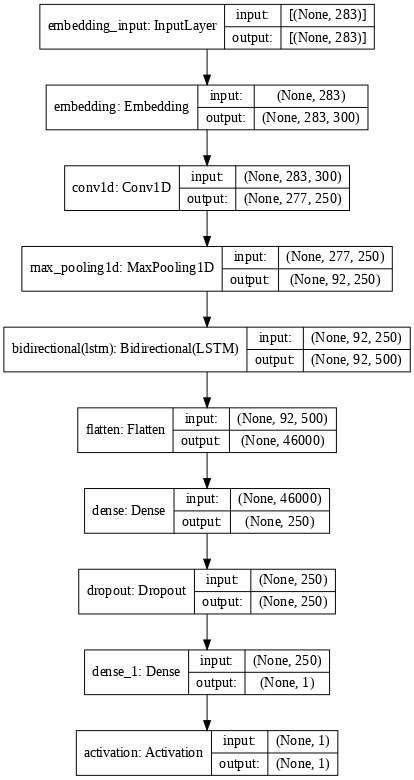

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model3, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

In [ ]:

nb_epochs=10

model3.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
csv_logger = CSVLogger('/content/training01.log', separator=',', append=False)
callbacks = [
 EarlyStopping(monitor='val_accuracy', mode='max',
                              patience=nb_epochs, verbose=1),
ModelCheckpoint(filepath = '/content/model_best.h5', monitor='val_accuracy', mode='max',
                            verbose=1, save_best_only=True, save_weights_only = True),
        csv_logger
    ]
history=model3.fit(X_tr, y_train,validation_data=(X_tes,y_val) ,epochs=nb_epochs,batch_size=32,verbose=1,callbacks=callbacks)


Epoch 1/10
377/377 [==============================] - 58s 60ms/step - loss: 0.4851 - accuracy: 0.8065 - val_loss: 0.5039 - val_accuracy: 0.8299

Epoch 00001: val_accuracy improved from -inf to 0.82990, saving model to /content/model_best.h5
Epoch 2/10
377/377 [==============================] - 22s 58ms/step - loss: 0.3680 - accuracy: 0.8581 - val_loss: 0.4305 - val_accuracy: 0.8661

Epoch 00002: val_accuracy improved from 0.82990 to 0.86611, saving model to /content/model_best.h5
Epoch 3/10
377/377 [==============================] - 22s 58ms/step - loss: 0.2937 - accuracy: 0.8878 - val_loss: 0.4034 - val_accuracy: 0.8664

Epoch 00003: val_accuracy improved from 0.86611 to 0.86645, saving model to /content/model_best.h5
Epoch 4/10
377/377 [==============================] - 22s 58ms/step - loss: 0.2321 - accuracy: 0.9128 - val_loss: 0.6055 - val_accuracy: 0.8605

Epoch 00004: val_accuracy did not improve from 0.86645
Epoch 5/10
377/377 [==============================] - 22s 58ms/step - l

# Graphe train test accuracy



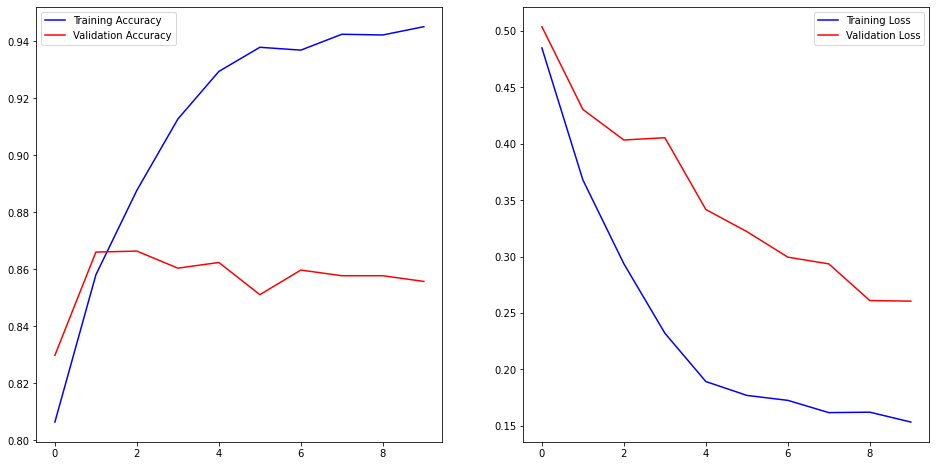

In [ ]:
history = pd.read_csv('/content/drive/MyDrive/DataMem/training01.log', sep=',', engine='python')
hist=history

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

f,ax=plt.subplots(1,2,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()



plt.show()

In [ ]:
y_test= model3.predict(X_tes)
y_test= np.round(y_test, 0)

print('\t\t\tPERFORMANCE\n')
print('Accuracy:', round(accuracy_score(y_val, y_test), 4), '\n')
print(classification_report(y_val, y_test))

			PERFORMANCE

Accuracy: 0.8558 

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      2338
           1       0.78      0.49      0.60       672

    accuracy                           0.86      3010
   macro avg       0.83      0.73      0.76      3010
weighted avg       0.85      0.86      0.84      3010



In [ ]:
#model3.save('/content/drive/MyDrive/DataMem/model_CNN_BiLSTM_emb40_Al_Jazeera_250_7.h5')

In [ ]:
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#print(model3.summary())
history=model3.fit(X_tr, y_train,validation_data=(X_tes,y_val) ,epochs=10,batch_size=64,verbose=1)

Epoch 1/10
189/189 [==============================] - 27s 129ms/step - loss: 0.1432 - accuracy: 0.9480 - val_loss: 1.0228 - val_accuracy: 0.8515
Epoch 2/10
189/189 [==============================] - 24s 125ms/step - loss: 0.1514 - accuracy: 0.9451 - val_loss: 0.8807 - val_accuracy: 0.8545
Epoch 3/10
189/189 [==============================] - 23s 124ms/step - loss: 0.1435 - accuracy: 0.9458 - val_loss: 0.7526 - val_accuracy: 0.8571
Epoch 4/10
189/189 [==============================] - 23s 123ms/step - loss: 0.1369 - accuracy: 0.9487 - val_loss: 0.8334 - val_accuracy: 0.8498
Epoch 5/10
189/189 [==============================] - 23s 123ms/step - loss: 0.1359 - accuracy: 0.9486 - val_loss: 0.7750 - val_accuracy: 0.8452
Epoch 6/10
189/189 [==============================] - 23s 123ms/step - loss: 0.1381 - accuracy: 0.9484 - val_loss: 0.6331 - val_accuracy: 0.8558
Epoch 7/10
189/189 [==============================] - 23s 123ms/step - loss: 0.1370 - accuracy: 0.9484 - val_loss: 0.8684 - val_ac

In [ ]:
y_test= model3.predict(X_tes)
y_test= np.round(y_test, 0)

print('\t\t\tPERFORMANCE\n')
print('Accuracy:', round(accuracy_score(y_val, y_test), 4), '\n')
print(classification_report(y_val, y_test))

			PERFORMANCE

Accuracy: 0.8588 

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      2338
           1       0.77      0.52      0.62       672

    accuracy                           0.86      3010
   macro avg       0.82      0.74      0.77      3010
weighted avg       0.85      0.86      0.85      3010



# **BiLSTM**

In [ ]:
model2=Sequential()
model2.add(embedding_layer ) 

model2.add(Bidirectional( LSTM(units=250,return_sequences=True)))

model2.add(Flatten())

model2.add(Dense(400, activation='relu'))
model2.add(Dropout(0.2))
#Output  Layer

model2.add(Dense(1, activation='sigmoid')) 

model2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

print(model2.summary())
#model2.fit(X_tr, y_train,validation_data=(X_tes,y_val) ,epochs=15,batch_size=32,verbose=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 283, 300)          8275800   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 283, 500)          1102000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 141500)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 400)               56600400  
_________________________________________________________________
dropout_2 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 401       
Total params: 65,978,601
Trainable params: 65,978,601
Non-trainable params: 0
__________________________________________

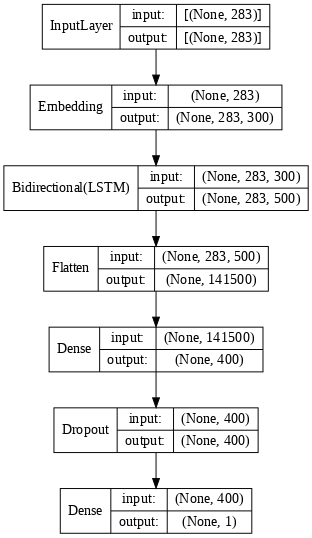

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model2, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = False, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

In [ ]:

model2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
csv_logger = CSVLogger('/content/training03.log', separator=',', append=False)
callbacks = [
 EarlyStopping(monitor='val_accuracy', mode='max',
                              patience=2, verbose=1),
#ModelCheckpoint(filepath = '/content/model_best_thebestt.h5', monitor='val_accuracy', mode='max',
                       #     verbose=1, save_best_only=True, save_weights_only = True),
        csv_logger
    ]


In [ ]:

opt=Adam(learning_rate=0.001)
model2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
history=model2.fit(X_tr, y_train,validation_data=(X_tes,y_val) ,epochs=10,batch_size=64,verbose=1,callbacks=callbacks)


Epoch 1/10
189/189 [==============================] - 33s 159ms/step - loss: 0.4536 - accuracy: 0.8379 - val_loss: 0.3493 - val_accuracy: 0.8704
Epoch 2/10
189/189 [==============================] - 29s 155ms/step - loss: 0.2765 - accuracy: 0.8969 - val_loss: 0.3736 - val_accuracy: 0.8578
Epoch 3/10
189/189 [==============================] - 29s 155ms/step - loss: 0.2223 - accuracy: 0.9190 - val_loss: 0.4184 - val_accuracy: 0.8688
Epoch 00003: early stopping


In [ ]:
y_test= model2.predict(X_tes)
y_test= np.round(y_test, 0)

print('\t\t\tPERFORMANCE\n')
print('Accuracy:', round(accuracy_score(y_val, y_test), 4), '\n')
print(classification_report(y_val, y_test))


			PERFORMANCE

Accuracy: 0.8688 

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2338
           1       0.81      0.54      0.65       672

    accuracy                           0.87      3010
   macro avg       0.84      0.75      0.78      3010
weighted avg       0.86      0.87      0.86      3010



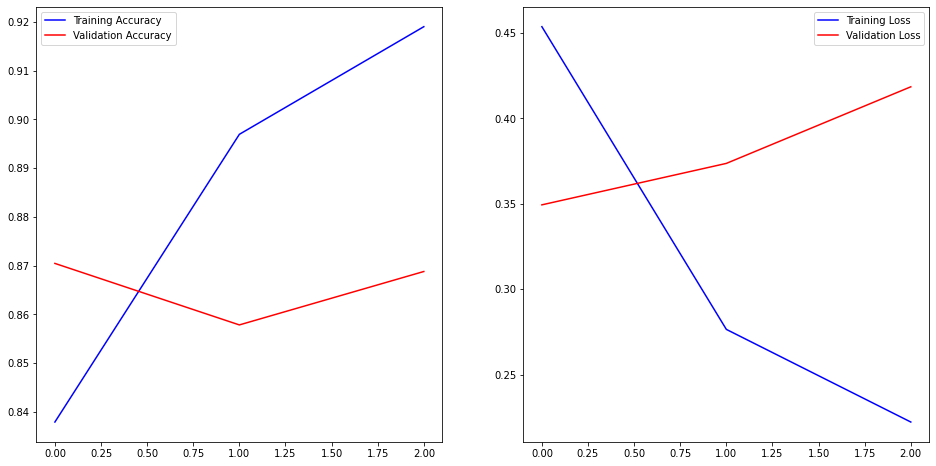

In [ ]:
history = pd.read_csv('/content/training03.log', sep=',', engine='python')
hist=history

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

f,ax=plt.subplots(1,2,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()



plt.show()

In [ ]:
#model2.save('/content/drive/MyDrive/DataMem/BiLSTM_emb40_Al_Jazeera.h5')

In [ ]:
K.clear_session()
opt=RMSprop(learning_rate=0.001)
model2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
history=model2.fit(X_tr, y_train,validation_data=(X_tes,y_val) ,epochs=5,batch_size=128,callbacks=callbacks)


Epoch 1/5
95/95 [==============================] - 20s 182ms/step - loss: 0.1403 - accuracy: 0.9480 - val_loss: 1.6062 - val_accuracy: 0.8575
Epoch 2/5
95/95 [==============================] - 17s 178ms/step - loss: 0.1335 - accuracy: 0.9502 - val_loss: 1.7444 - val_accuracy: 0.8512
Epoch 3/5
95/95 [==============================] - 17s 179ms/step - loss: 0.1325 - accuracy: 0.9506 - val_loss: 1.6828 - val_accuracy: 0.8578
Epoch 4/5
95/95 [==============================] - 17s 177ms/step - loss: 0.1314 - accuracy: 0.9499 - val_loss: 1.8553 - val_accuracy: 0.8575
Epoch 5/5
95/95 [==============================] - 17s 175ms/step - loss: 0.1345 - accuracy: 0.9498 - val_loss: 1.8554 - val_accuracy: 0.8555
Epoch 00005: early stopping


In [ ]:
scores = model2.evaluate(X_tes, y_val, verbose=1)
print("\n%s: %.2f%%" % (model2.metrics_names[1], scores[1]*100))


95/95 [==============================] - 2s 21ms/step - loss: 1.8554 - accuracy: 0.8555

accuracy: 85.55%


In [ ]:
y_test= model2.predict(X_tes)
y_test= np.round(y_test, 0)

print('\t\t\tPERFORMANCE\n')
print('Accuracy:', round(accuracy_score(y_val, y_test), 4), '\n')
print(classification_report(y_val, y_test))

			PERFORMANCE

Accuracy: 0.8555 

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      2338
           1       0.74      0.54      0.62       672

    accuracy                           0.86      3010
   macro avg       0.81      0.74      0.77      3010
weighted avg       0.85      0.86      0.85      3010



# Hybridation

Modif param

In [ ]:
        model4= Sequential()
        model4.add(embedding_layer ) 
        model4.add(Conv1D(250, 3,activation='relu',padding="valid", strides=1))
        
        model4.add(MaxPooling1D(pool_size=3))
        model4.add(Bidirectional(LSTM(units=250,return_sequences=True)))
        model4.add(Flatten())
        model4.add(Dense(250, activation='relu'))
        model4.add(Dropout(0.3))
        model4.add(Dense(1))
        model4.add(Activation('sigmoid'))
        
#model4.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
print(model4.summary())
#model4.fit(X_tr, y_train,validation_data=(X_tes,y_val) ,epochs=15,batch_size=32,verbose=1)
        

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 283, 300)          8275800   
_________________________________________________________________
conv1d (Conv1D)              (None, 281, 250)          225250    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 93, 250)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 93, 500)           1002000   
_________________________________________________________________
flatten (Flatten)            (None, 46500)             0         
_________________________________________________________________
dense (Dense)                (None, 250)               11625250  
_________________________________________________________________
dropout (Dropout)            (None, 250)               0

In [ ]:
#model3.save('/content/drive/MyDrive/DataMem/model_CNN_BiLSTM_emb40_Al_Jazeera_250_3.h5')

In [ ]:
opt=Adam(learning_rate=0.01)
model4.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

history=model4.fit(X_tr, y_train,validation_data=(X_tes,y_val) ,epochs=15,batch_size=32,verbose=1,callbacks=callbacks)

Epoch 1/15
377/377 [==============================] - 47s 117ms/step - loss: 1.5580 - accuracy: 0.7553 - val_loss: 0.5332 - val_accuracy: 0.7767
Epoch 2/15
377/377 [==============================] - 43s 114ms/step - loss: 0.6162 - accuracy: 0.7593 - val_loss: 0.5323 - val_accuracy: 0.7767
Epoch 3/15
377/377 [==============================] - 43s 115ms/step - loss: 0.5480 - accuracy: 0.7627 - val_loss: 0.5325 - val_accuracy: 0.7767
Epoch 00003: early stopping


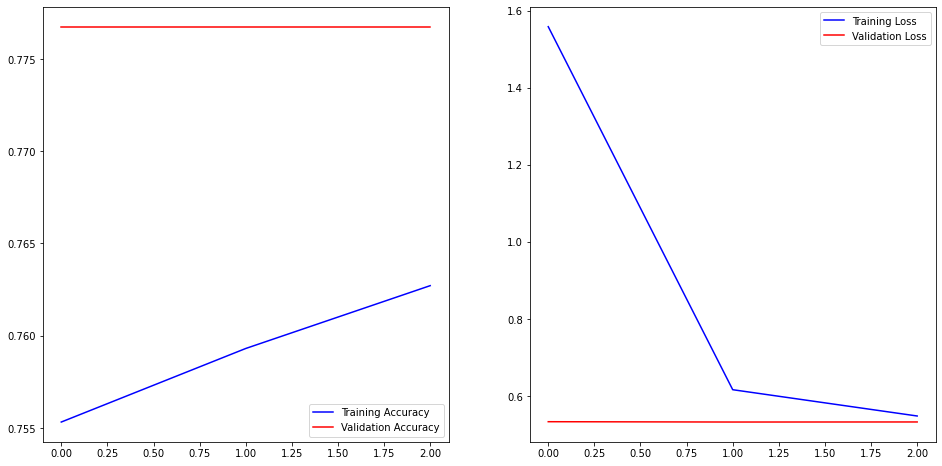

In [ ]:



hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

f,ax=plt.subplots(1,2,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()



plt.show()

In [ ]:
y_test= model4.predict(X_tes)
y_test= np.round(y_test, 0)

print('\t\t\tPERFORMANCE\n')
print('Accuracy:', round(accuracy_score(y_val, y_test), 4), '\n')
print(classification_report(y_val, y_test))

			PERFORMANCE

Accuracy: 0.7767 

              precision    recall  f1-score   support

           0       0.78      1.00      0.87      2338
           1       0.00      0.00      0.00       672

    accuracy                           0.78      3010
   macro avg       0.39      0.50      0.44      3010
weighted avg       0.60      0.78      0.68      3010



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:

phrase1 = ['سيد فيصل إحترامي وتعلم']
phrase2=['أمريكا قتلت بالامس معوق رفض رفع يديه فماذا تريد من الشرطة المصرية أن تفعل عندما تتعامل مع مسلحين معهم متفجرات',]

seq1= tokenizer.texts_to_sequences(phrase1)
seq2= tokenizer.texts_to_sequences(phrase2)
data1 = pad_sequences(seq1, maxlen= 283 , padding='post')
data2 = pad_sequences(seq2, maxlen= 283 , padding='post')

prediction1=model3.predict(data1)
prediction2=model3.predict(data2)
print('predection \n  1 : ',prediction1 , '\n 2: ',prediction2)
###################################
##classes= df['languagecomment'].unique()
##print(classes)
##print(np.argmax(prediction))
##pred_name = classes[np.argmax(prediction)]
##print(pred_name)

predection 
  1 :  [[3.0379247e-13]] 
 2:  [[5.5245777e-09]]
